# Production Model

The production model is created from an aggregation of 3 different models - Naive Bayes, Logistic Regression, and Support Vector Machines

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import nltk

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import MultinomialNB

from sklearn.svm import SVC
from mlxtend.preprocessing import DenseTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import VotingClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import pickle
import gzip

In [2]:
# importing the cleaned reddit posts
posts = pd.read_csv("../data/cleaned_reddit_posts.csv")

X = posts["title"]
y = posts["subreddit"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=2020)

#Calculating the baseline accuracy of the data
y_test.value_counts(normalize=True)

0    0.506923
1    0.493077
Name: subreddit, dtype: float64

In [3]:
#loading models using pickle
#with help from https://stackabuse.com/scikit-learn-save-and-restore-models/

with open('../data/saved_models/nb_model.pkl', 'rb') as nb_file:
    best_nb = pickle.load(nb_file)

with open('../data/saved_models/logreg_model.pkl', 'rb') as logreg_file:
    best_logreg = pickle.load(logreg_file)
    
with gzip.open('../data/saved_models/svm_model.pgz', 'rb') as svm_file:
    best_svm = pickle.load(svm_file)

In [4]:
#Aggregating the predictions from logreg, nb, and svm to create production model
vote = VotingClassifier(estimators=[
    ("logreg" , best_logreg),
    ("nb" , best_nb),
    ("svm" , best_svm)
],
voting = "soft")

vote.fit(X_train,y_train)

print(f'Training {vote.score(X_train,y_train)}')
print(f'Testing {vote.score(X_test,y_test)}')

Training 0.9721794871794872
Testing 0.9334615384615385


Training Accuracy = 0.972

Testing Accuracy = 0.934

In [5]:
temp_dict = {"X_test" : X_test , "y_test" : y_test}
preds_and_posts = pd.DataFrame(temp_dict)
preds_and_posts["logreg_preds"] = best_logreg.predict(X_test)
preds_and_posts["nb_preds"] = best_nb.predict(X_test)
preds_and_posts["svm_preds"] = best_svm.predict(X_test)
preds_and_posts["vote_preds"] = vote.predict(X_test)
preds_and_posts.head()

,X_test,y_test,logreg_preds,nb_preds,svm_preds,vote_preds
8348,ELI5: Why the Fourier transform seems to have ...,1,1,1,1,1
3918,Aita for threading to call the police after my...,0,0,0,0,0
5926,ELI5: How is unit-uniqueness guaranteed in ext...,1,1,1,1,1
1856,Aita for wishing bad on my family,0,0,0,0,0
2719,WIBTA If I outed my sister as lesbian to the r...,0,0,0,0,0


In [6]:
#how many posts the each model misclassified
print(f'Logreg miss classified - {len(preds_and_posts[preds_and_posts["y_test"] != preds_and_posts["logreg_preds"]])}')
print(f'Nb miss classified - {len(preds_and_posts[preds_and_posts["y_test"] != preds_and_posts["nb_preds"]])}')
print(f'Svm miss classified - {len(preds_and_posts[preds_and_posts["y_test"] != preds_and_posts["svm_preds"]])}')
print(f'Vote miss classified - {len(preds_and_posts[preds_and_posts["y_test"] != preds_and_posts["vote_preds"]])}')

Logreg miss classified - 209
Nb miss classified - 176
Svm miss classified - 226
Vote miss classified - 173


In [7]:
#how many different posts were misclassified
len(preds_and_posts[(preds_and_posts["y_test"] != preds_and_posts["logreg_preds"]) | (preds_and_posts["y_test"] != preds_and_posts["nb_preds"]) | (preds_and_posts["y_test"] != preds_and_posts["svm_preds"]) ])

329

In [8]:
#looing at the status which the model miss classified
preds_and_posts[preds_and_posts["y_test"] != preds_and_posts["vote_preds"]].iloc[2:6]

,X_test,y_test,logreg_preds,nb_preds,svm_preds,vote_preds
9300,ELI5 In ladder toss lawn game if the bolas wra...,1,1,0,1,0
3571,AITA for “ripping people off” in my plant sales,0,1,1,1,1
8437,ELI5: How does porn generate revenue?,1,1,0,1,0
2931,AITA - I want to refuse coming in to work beca...,0,1,1,1,1


### Vote Classifier Confusion Matrix

<Figure size 864x720 with 0 Axes>

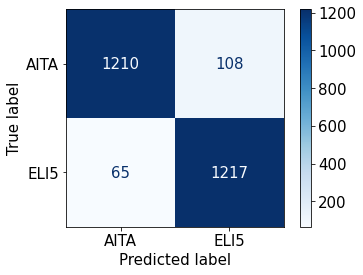

In [9]:
#generate confusion matrix values from ensemble model
tn,fp,fn,tp = confusion_matrix(y_test,preds_and_posts["vote_preds"]).ravel()
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 15})
plot_confusion_matrix(vote, X_test, y_test, cmap='Blues', values_format='d',display_labels=["AITA","ELI5"]);

In [10]:
#specificity
tn/(tn+fp)

0.9180576631259484

In [11]:
#sensitivity
tp/(tp+fn)

0.9492979719188768

### Naive Bayes Confusion Matrix

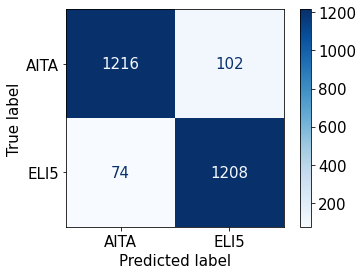

In [12]:
plot_confusion_matrix(best_nb, X_test, y_test, cmap='Blues', values_format='d',display_labels=["AITA","ELI5"]);

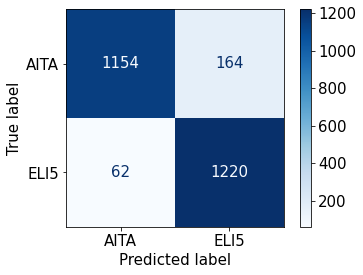

In [13]:
plot_confusion_matrix(best_svm, X_test, y_test, cmap='Blues', values_format='d',display_labels=["AITA","ELI5"]);

# Conclusions

Overall the ensemble model does a very good job at predicting subreddits based on title words alone. As no prediction is worse than another, overall accuracy is the best metric to compare when moving forward. 

The vote classifier takes the predictions from the 3 component models (mNB,logreg,SVM) and uses those predictions to generate an overall prediction. This model preforms especially well when all of the component models are around the same level of accuracy (which is the case here)

The model struggles to correctly identify technical questions based on personal concepts ( ie sex, kids, marriage)

In general AITA posts are easier to determine than ELI5 posts as the common word choice is more consistent which allows the model to have an easier time predicting 